In [1]:
import logging
import ocelot
from ocelot.common.globals import *
from ocelot.optics.wave import *
from ocelot.optics.wave import RadiationField, dfl_waistscan
from ocelot.optics.wave import imitate_sase_dfl, wigner_dfl, dfl_waistscan, generate_gaussian_dfl
from ocelot.gui.dfl_plot import plot_dfl, plot_wigner, plot_dfl_waistscan
from copy import deepcopy
from ocelot import ocelog

ocelog.setLevel(logging.ERROR)
#ocelog.setLevel(logging.DEBUG)
#ocelog.setLevel(logging.INFO)

initializing ocelot...


<a id='gen_dfl'></a>
### Generating RadiationField
OCELOT has the RadiationField object which represents an electric field.

In [2]:
dfl = RadiationField()

We start to consider properties of this object using a model gaussian beam. The gaussian beam can be defined with arguments:

In [3]:
E_pohoton = 8000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'rho':1.0e-4, 
        'shape':(301,301,3),           #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(200e-6,200e-6,35e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(10e-6,10e-6,3e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(-20,20),     #(Z_x,Z_y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        'en_pulse':None,               #total energy or max power of the pulse, use only one
        'power':1e6,
        }
dfl = generate_gaussian_dfl(**kwargs);  #Gaussian beam defenition

The RadiationField object is a 3D data cube with a  ```dfl.shape() = (Nz, Nx, Ny)``` and a step for each axis ```dfl.dx```, ```dfl.dy```, ```dfl.dz``` which are defined as dx, dy, dz = dgrid[0]/Nx, dgrid[1]/Ny, dgrid[2]/Nz.

We created the gaussian beam at z=0 meters and with position its x waist at -20 meters and y waist at 20 meters

<a id='plot_radiation_field'></a>
### Plotting Radiation Field

To visulize the radiation one can use ```plot_dfl()``` function. There is an option to plot the radiation in what domain you want (transverse ```'s'``` and ```'k'```, longitudinal ```'t'``` and ```'f'```) and any combination of it. 

/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alte

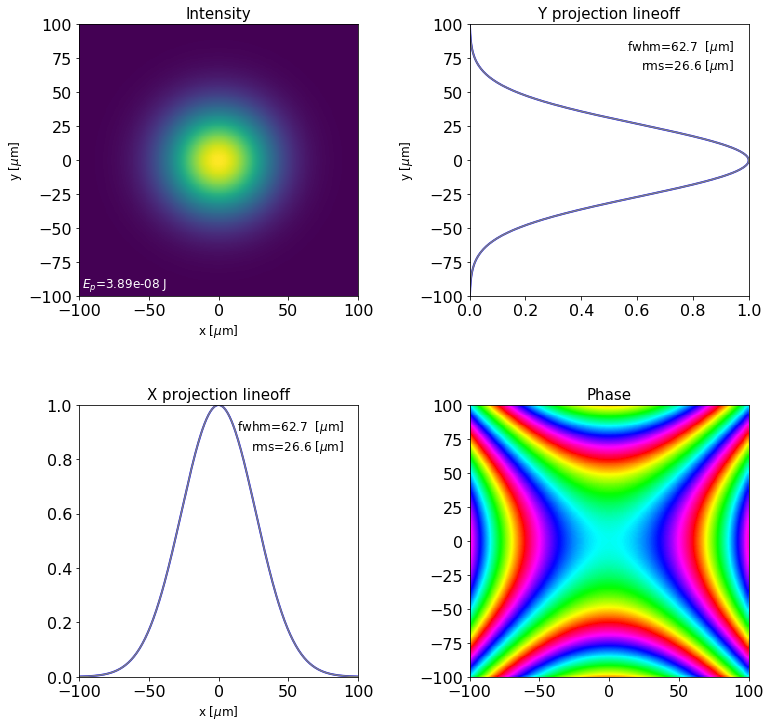

In [4]:
plot_dfl(dfl, #RadiationField() object
         domains=None, #longitudinal domain + transverse domain ('t' or 'f' + 's' or 'k') 
                       #(example: 'tk' - time/inversespace domain)
         z_lim=[],     #sets the boundaries to CUT the dfl object in z to ranges of e.g. [2,5] um or nm depending on freq_domain=False of True
         xy_lim=[],    #sets the boundaries to SCALE the dfl object in x and y to ranges of e.g. [2,5] um or urad depending on far_field=False of True
         figsize=4,    #rescales the size of the figure
         cmap='viridis',#color map which will be used for plotting (http://matplotlib.org/users/colormaps.html)
         phase=True,  #bool type variable, can replace Z projection or spectrum with phase front distribution z dimensions correspondingly
         fig_name='default_dfl_plot', #the desired name of the output figure, would be used as suffix to the image filename if savefig==True
         auto_zoom=False, #bool type variable, automatically scales xyz the images to the (1%?) of the intensity limits
         column_3d=False,  #bool type variable, plots top and side views of the radiation distribution
         savefig=False,   #bool type variable, allow to save figure to image (savefig='png' (default) or savefig='eps', etc...)
         showfig=True,    #bool type variable, allow to display figure (slower)
         return_proj=False, #bool type variable, returns [xy_proj,yz_proj,xz_proj,x,y,z] array.
         line_off_xy=True, #bool type variable, if True, the transverse size of radiation are calculated at x=0 and y=0 position, otherwise marginal distribution are used
         log_scale=0,     #bool type variable, if True, log scale will be used for potting
         debug=1,
         cmap_cutoff=0)   #0 <= cmap_cutoff <= 1; all pixels that have intensity lower than cmap_cutoff will be seted to white color



The OCELOT toolkit has a function that scans fwhm, std, power on axis and the total power over the radiation propogation direction in some range with a set step. That make a reperesentation of the beam size and helps to define the position of a waist.   

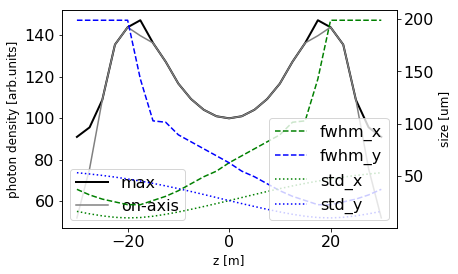

In [5]:
#%% Scanning for waist position
w_scan = dfl_waistscan(dfl, 
                       z_pos=np.linspace(-30,30,25), 
                       projection=0)

plot_dfl_waistscan(w_scan, 
                   fig_name='waist scan results', 
                   showfig=True, 
                   savefig=False)

OCELOT has a propagator which calculates the radiation at some distance $z$ with help of free space response function.

If $E_0(x,y,0; t)$ is an initial field distribution, $E_0(k_x,k_y,0; t)$ is the spatial Fourier transform of this field and $E_0(x,y,z; t)$ is the field distribution at z then we can define responce function as 
$H(k_x, k_y, z) = \cfrac{\vec{{E}}(k_x, k_y, z; t)}{\vec{{E}}(k_x, k_y, 0; t)}$. Explicitly:

$H(k_x, k_y, z) = \exp\bigg[ik_0z\sqrt{1 - \cfrac{k^2_x}{k^2_0} - \cfrac{k^2_y}{k^2_0}} \bigg]$.

We propagate the field to the y waist.

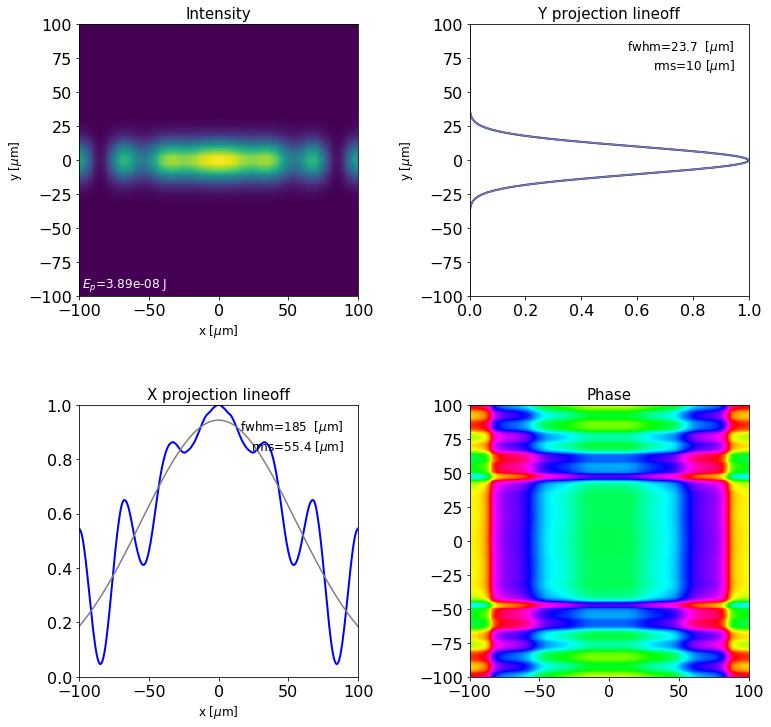

In [6]:
dfl0 = deepcopy(dfl)
dfl0.prop(z=20 #propagation distance [m]
         )
plot_dfl(dfl0, fig_name='dfl_prop', phase=True, column_3d=False)

However, at this propagation distances the field has errors and artifacts which is seen as the fluctuations of intensity initially appearing at  edge of the grid. Fortunately, this difficulties may be overcome if we recalculate the size of the grid. In OCELOT there is the function ```prop_m()``` that, roughly speaking, resizes the mesh at ```m``` times.

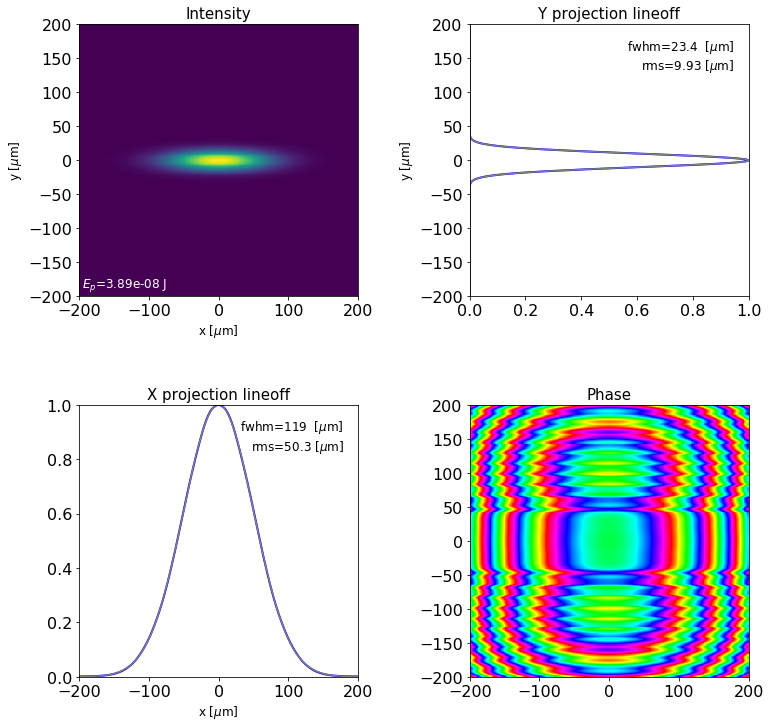

In [7]:
dfl0 = deepcopy(dfl)
dfl0.prop_m(z=20, #propagation distance [m]
            m=2   #mesh resize coefficient
            )
plot_dfl(dfl0, fig_name='dfl_prop', phase=True, column_3d=False)

<a id='dif_on_ap'></a>
### Diffraction on an aperture


In OCELOT we can introduce an aperture and propagate the radiation through it.

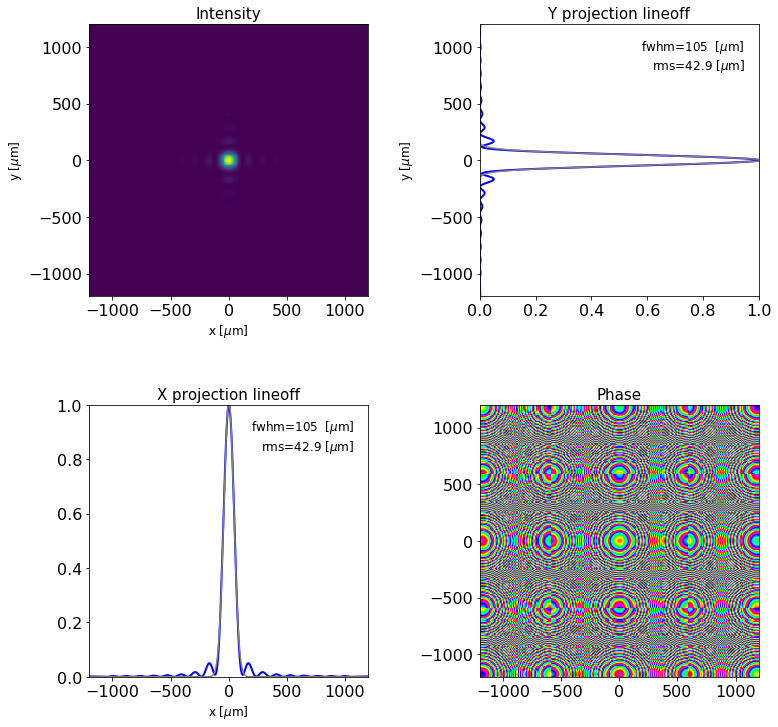

In [9]:
E_pohoton = 8000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'rho':  1.0e-4, 
        'shape':(301,301,1),         #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(200e-6,200e-6,35e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(10e-6,10e-6,3e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(0,0),#(x,y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        'en_pulse':None,               #total energy or max power of the pulse, use only one
        'power':1e6,
        }

dfl1 = generate_gaussian_dfl(**kwargs);  #Gaussian beam defenition
dfl1.prop_m(z=50, m=3)
#plot_dfl(dfl1, fig_name='dfl_prop', phase=True, column_3d=False)

dfl1 = dfl_ap(dfl1, ap_x=4e-5, ap_y=4e-5)
#plot_dfl(dfl1, fig_name='dfl_ap', phase=True, column_3d=False)
dfl1.prop_m(z=30, m=4)
plot_dfl(dfl1, fig_name='dfl_ap_prop', phase=True, column_3d=False)
